In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

Normalizing casings for the review text to lower case and extracting the text into a list for easier manipulation.
Next we Tokenize the reviews using NLTKs word_tokenize function and Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.
And since for the topic model we just need nouns, therefore we filter all the POS tags that correspond to nouns.
we Lemmatiz these nouns words and finally remove stopwords and punctuation. 

<>:8: SyntaxWarning: invalid escape sequence '\A'
<>:8: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_101961/2493357301.py:8: SyntaxWarning: invalid escape sequence '\A'
  print('Columns with N\A values:')
[nltk_data] Downloading package punkt to /home/rynem8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/rynem8/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/rynem8/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/rynem8/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/rynem8/nltk_data...


Dataframe:
        sentiment                                             review
0              1             Good but need updates and improvements
1              0  Worst mobile i have bought ever, Battery is dr...
2              1  when I will get my 10% cash back.... its alrea...
3              1                                               Good
4              0  The worst phone everThey have changed the last...
...          ...                                                ...
14670          1  I really like the phone, Everything is working...
14671          1  The Lenovo K8 Note is awesome. It takes best p...
14672          1                       Awesome Gaget.. @ this price
14673          1  This phone is nice processing will be successf...
14674          1      Good product but the pakeging was not enough.

[14675 rows x 2 columns]
Columns with Null values:
0
Columns with N\A values:
0


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rynem8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/rynem8/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


New dataframe after cleaning dataset:
        sentiment                                             review  \
0              1             good but need updates and improvements   
1              0  worst mobile i have bought ever, battery is dr...   
2              1  when i will get my 10% cash back.... its alrea...   
3              1                                               good   
4              0  the worst phone everthey have changed the last...   
...          ...                                                ...   
14670          1  i really like the phone, everything is working...   
14671          1  the lenovo k8 note is awesome. it takes best p...   
14672          1                       awesome gaget.. @ this price   
14673          1  this phone is nice processing will be successf...   
14674          1      good product but the pakeging was not enough.   

                                        tokenized_review  \
0          [good, but, need, updates, and, impro

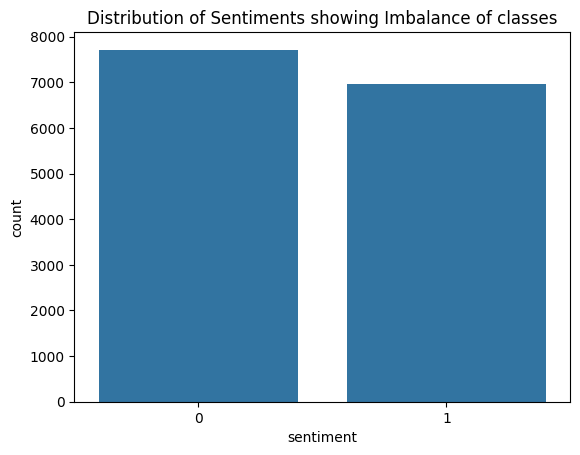

In [2]:
# importing the data files using pandas.read_csv reads the csv file 
rawIdata = pd.read_csv('K8 Reviews v0.2.csv') # training dataset
print('Dataframe:\n',rawIdata)

# Check for missing, null and duplicate values 
print('Columns with Null values:')
print(rawIdata['sentiment'].isnull().sum())
print('Columns with N\A values:')
print(rawIdata['sentiment'].isna().sum())

#  Clean the data by removing or correcting any errors
rawIdata['sentiment'].dropna(inplace=True)

# Data Cleaning
# Normalise the casing of the review text
rawIdata['review'] = rawIdata['review'].str.lower()

# Normalise terms with dilect characters. NFKD is a normalisation form that splits the base character from its diacritic and then converts it into ascii.
rawIdata['review'] = rawIdata['review'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Removing user handles starting with @
rawIdata['review'] = rawIdata['review'].replace(r'@\w+', '', regex=True)

# Removing URLs
rawIdata['review']= rawIdata['review'].replace(r'http\S+', '', regex=True)

# Using word Tokenizer from NLTK, tokenize the reviews into individual terms
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
rawIdata['tokenized_review'] = rawIdata['review'].apply(word_tokenize)

# Perform POS tagging
nltk.download('averaged_perceptron_tagger')
rawIdata['pos_tagged'] = rawIdata['tokenized_review'].apply(nltk.pos_tag)

# Identify and filter nouns
# Nouns are typically denoted by the following tags in NLTK: NN, NNS, NNP, NNPS
nouns = ['NN', 'NNS', 'NNP', 'NNPS']
rawIdata['nouns'] = rawIdata['pos_tagged'].apply(lambda x: [word for word, pos in x if pos in nouns])


# Lemmatize the tokens
# Lemmatize the nouns to ensure different forms of a word are treated as one
lemmatizer = WordNetLemmatizer()
rawIdata['lemmatized_nouns'] = rawIdata['nouns'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remove english stopwords and additional words like amp, rt, etc. from the reviews using NLTK stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['amp', 'rt', 'via', 'retweet','ur', 'u', 'w', 'b', 'c', 'im', 'dont', 'cant', 'thats', 'wont', 'isnt', 'didnt', 'couldnt', 'wouldnt'])
rawIdata['cleaned_nouns'] = rawIdata['lemmatized_nouns'].apply(lambda x: [item for item in x if not item in stop_words])

# Reseting the row index to start numbering from 0
rawIdata.reset_index(drop=True, inplace=True) 
CleanIdata =rawIdata
print('New dataframe after cleaning dataset:\n',CleanIdata)


# Distribution of sentiment classes for training dataset
sns.countplot(x='sentiment', data=CleanIdata)
plt.title('Distribution of Sentiments showing Imbalance of classes')
plt.show()


Topic Modeling Using LDA
Creating a topic model using LDA on the cleaned-up data with 12 topics.
Determining which of the topics can be combined.
Creating a topic model using LDA with what you think is the optimal number of topics snd, finding the coherence of the model.

In [3]:
# Creating a dictionary and corpus needed for LDA topic modeling
dictionary = corpora.Dictionary(CleanIdata['cleaned_nouns'])
corpus = [dictionary.doc2bow(text) for text in CleanIdata['cleaned_nouns']]

# Training the LDA model with an initial guess of 12 topics
lda_model = LdaModel(corpus, num_topics=12, id2word=dictionary, passes=15)

# Printing the topics discovered by LDA, showing the top 10 terms for each
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Coherence Score
# Calculate the coherence score to evaluate the quality of the topic model
coherence_model = CoherenceModel(model=lda_model, texts=CleanIdata['cleaned_nouns'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')

(0, '0.210*"camera" + 0.089*"quality" + 0.056*"phone" + 0.049*"battery" + 0.028*"performance" + 0.020*"mode" + 0.018*"processor" + 0.016*"sound" + 0.015*"display" + 0.014*"feature"')
(1, '0.145*"price" + 0.141*"problem" + 0.098*"phone" + 0.090*"heating" + 0.057*"range" + 0.023*"issue" + 0.014*"feature" + 0.013*"system" + 0.011*"option" + 0.011*"sensor"')
(2, '0.092*"network" + 0.083*"issue" + 0.046*"sim" + 0.044*"call" + 0.043*"problem" + 0.028*"superb" + 0.024*"jio" + 0.024*"*" + 0.023*"card" + 0.022*"handset"')
(3, '0.245*"phone" + 0.038*"feature" + 0.033*"screen" + 0.029*"lenovo" + 0.023*"software" + 0.022*"update" + 0.016*"option" + 0.016*"time" + 0.014*"issue" + 0.013*"note"')
(4, '0.500*"product" + 0.030*"smartphone" + 0.026*"thanks" + 0.022*"lenovo" + 0.017*"amazon" + 0.016*"class" + 0.016*"awesome" + 0.011*"plz" + 0.010*"rest" + 0.009*"team"')
(5, '0.144*"note" + 0.090*"k8" + 0.045*"lenovo" + 0.034*"hai" + 0.017*"notification" + 0.014*"ho" + 0.012*"call" + 0.011*"k4" + 0.011*"m

Business Analysis and Topic Optimization
Naming each of the identified topics and Analyzing the topics through the business lens.
Topic Naming and Presentation by creating a table with the topic name and the top 10 terms in each to present to the business.

In [4]:
# After reviewing the initial topics, deciding if some topics should be combined or if the number of topics should be adjusted
# Retraining the LDA model with the optimal number of topics (e.g., 8 topics)
lda_model_optimized = LdaModel(corpus, num_topics=8, id2word=dictionary, passes=15)
coherence_model_optimized = CoherenceModel(model=lda_model_optimized, texts=CleanIdata['cleaned_nouns'], dictionary=dictionary, coherence='c_v')
coherence_score_optimized = coherence_model_optimized.get_coherence()
print(f'Optimized Coherence Score: {coherence_score_optimized}')

# Assigning business-friendly names to the topics based on the terms that define them
topic_names = ["Battery Life", "Camera Quality", "Performance", "Price", "Build Quality", "Display", "Software", "Customer Service"]

# Creating a table with the topic names and the top 10 terms for each topic
top_terms_per_topic = {name: lda_model_optimized.show_topic(i, 10) for i, name in enumerate(topic_names)}
top_terms_df = pd.DataFrame(top_terms_per_topic)
print(top_terms_df)

Optimized Coherence Score: 0.5677867468876793
              Battery Life              Camera Quality  \
0     (product, 0.2719442)      (service, 0.049435817)   
1      (note, 0.058699377)        (phone, 0.041963626)   
2          (k8, 0.0444858)       (amazon, 0.040020477)   
3       (money, 0.0421704)           (hai, 0.02203784)   
4     (lenovo, 0.03726624)     (customer, 0.020650001)   
5      (waste, 0.03509608)  (replacement, 0.018781183)   
6  (delivery, 0.028559154)            (h, 0.017186934)   
7   (handset, 0.026139945)          (day, 0.016414145)   
8    (mobile, 0.021915695)        (lenovo, 0.01593468)   
9    (amazon, 0.018004887)       (return, 0.015852077)   

              Performance                       Price           Build Quality  \
0   (problem, 0.13676399)       (battery, 0.17909318)     (phone, 0.28034323)   
1      (phone, 0.0875702)           (.., 0.080900475)     (price, 0.07588201)   
2     (issue, 0.07446097)         (phone, 0.07235754)   (camera, 0.03174